In [1]:
from qiskit.tools.jupyter import *

from qiskit import IBMQ
IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider=IBMQ.get_provider(hub='ibm-q-research', group='uni-maryland-1', project='main')
backend = provider.get_backend('ibmq_armonk')

In [2]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [3]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [4]:
backend_defaults = backend.defaults()

In [5]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 20 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.971855969373953 GHz.
The sweep will go from 4.961855969373953 GHz to 4.981855969373953 GHz in steps of 1.0 MHz.


In [62]:
# number of shots for our experiments
NUM_SHOTS = 1024

In [6]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [7]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
# This Pulse module helps us build sampled pulses for common pulse shapes
from qiskit.pulse import library as pulse_lib


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.05
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In [8]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [9]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [10]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [11]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

/Users/mingtsoweii/miniconda3/lib/python3.8/site-packages/qiskit/pulse/schedule.py:1534: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  warnings.warn('Legacy pulse drawer is deprecated. '


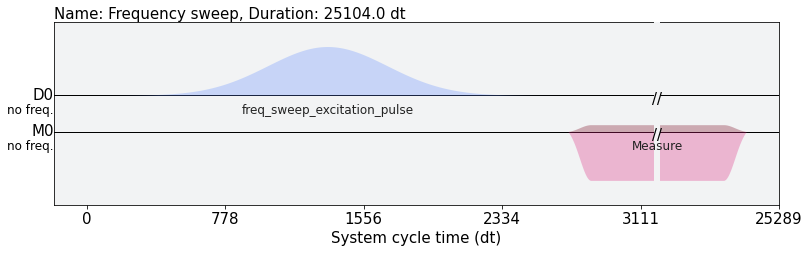

In [12]:
schedule.draw(label=True)

In [13]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

In [14]:
job = backend.run(frequency_sweep_program)

<ipython-input-14-b1426b634c8f>:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(frequency_sweep_program)


In [15]:
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

60726dd6159ff958bc3f076d
Job Status: job has successfully run


In [16]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

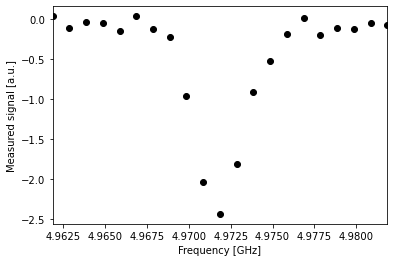

In [30]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [18]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [19]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-5, 4.975, 1, 5] # initial parameters for curve_fit
                                )

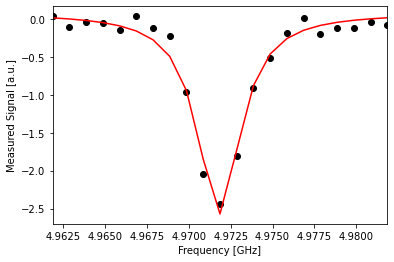

In [31]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [32]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 8)} GHz to {round(rough_qubit_frequency/GHz, 8)} GHz.")

We've updated our qubit frequency estimate from 4.97185597 GHz to 4.97180093 GHz.


In [33]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [34]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

/Users/mingtsoweii/miniconda3/lib/python3.8/site-packages/qiskit/pulse/schedule.py:1534: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  warnings.warn('Legacy pulse drawer is deprecated. '


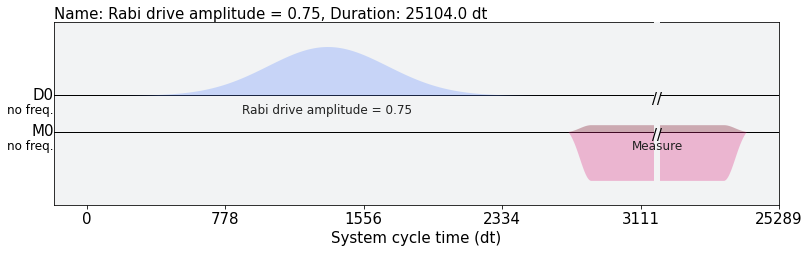

In [35]:
rabi_schedules[-1].draw(label=True)

In [36]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)

In [37]:
print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

60726ebb87332535ebe5ce4d


<ipython-input-37-631b1e53aac5>:2: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(rabi_experiment_program)


Job Status: job has successfully run


In [38]:
rabi_results = job.result(timeout=120)

In [39]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

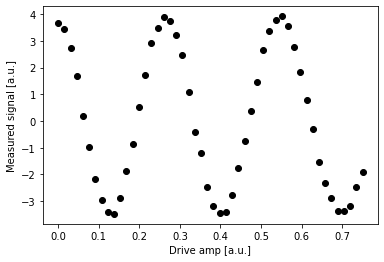

In [41]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

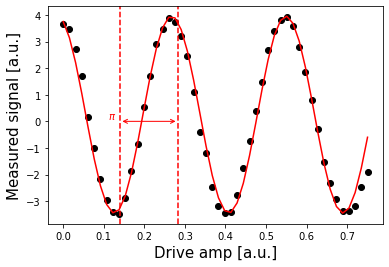

In [54]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [4, -4, 0.4, 2*np.pi])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [56]:
pi_amp_01 = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp_01}")

Pi Amplitude = 0.14096173612665405


In [57]:
pi_pulse_01 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_01, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_01')

In [58]:
# Create the two schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="zero schedule")
zero_schedule |= measure

# Excited state schedule
one_schedule = pulse.Schedule(name="one schedule")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan) 
one_schedule |= measure << one_schedule.duration

/Users/mingtsoweii/miniconda3/lib/python3.8/site-packages/qiskit/pulse/schedule.py:1534: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  warnings.warn('Legacy pulse drawer is deprecated. '


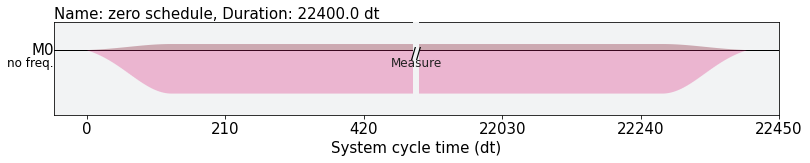

In [59]:
zero_schedule.draw(label=True)

/Users/mingtsoweii/miniconda3/lib/python3.8/site-packages/qiskit/pulse/schedule.py:1534: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  warnings.warn('Legacy pulse drawer is deprecated. '


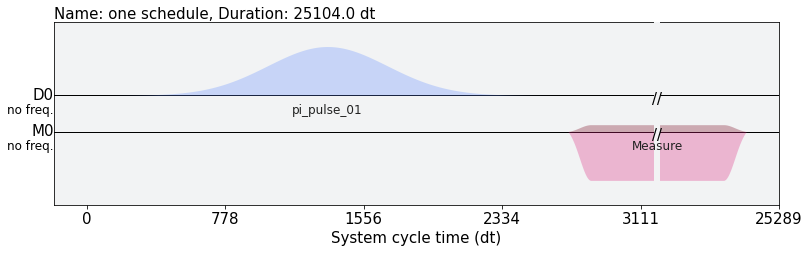

In [60]:
one_schedule.draw(label=True)

In [64]:
# Assemble the schedules into a program
IQ_01_program = assemble([zero_schedule, one_schedule],
                          backend=backend,
                          meas_level=1,
                          meas_return='single',
                          shots=NUM_SHOTS,
                          schedule_los=[{drive_chan: rough_qubit_frequency}] * 2)

In [65]:
IQ_01_job = backend.run(IQ_01_program)

<ipython-input-65-14e25bfea407>:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  IQ_01_job = backend.run(IQ_01_program)


In [66]:
print(IQ_01_job.job_id())
job_monitor(IQ_01_job)

60727462159ff9dd7c3f07a2
Job Status: job has successfully run


In [68]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

In [69]:
# Get job data (single); split for zero and one
IQ_01_data = get_job_data(IQ_01_job, average=False)
zero_data = IQ_01_data[0]
one_data = IQ_01_data[1]

In [70]:
def IQ_01_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for |0>, |1>. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')

    # Plot a large dot for the average result of the zero and one states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1 discrimination", fontsize=15)

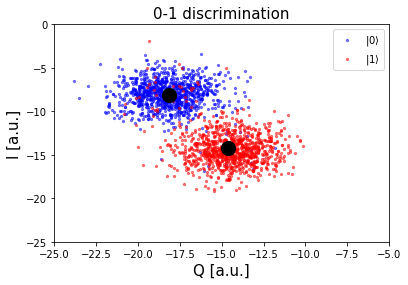

In [72]:
x_min = -25
x_max = -5
y_min = -25
y_max = 0
IQ_01_plot(x_min, x_max, y_min, y_max)

In [73]:
def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [74]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  

IQ_01_data = np.concatenate((zero_data_reshaped, one_data_reshaped))
print(IQ_01_data.shape) # verify IQ data shape

(2048, 2)


In [76]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

In [77]:
# construct vector w/ 0's and 1's (for testing)
state_01 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_01 = np.concatenate((state_01, np.ones(NUM_SHOTS)))
print(len(state_01))

# Shuffle and split data into training and test sets
IQ_01_train, IQ_01_test, state_01_train, state_01_test = train_test_split(IQ_01_data, state_01, test_size=0.5)

2048


In [78]:
# Set up the LDA
LDA_01 = LinearDiscriminantAnalysis()
LDA_01.fit(IQ_01_train, state_01_train)

LinearDiscriminantAnalysis()

In [79]:
# test on some simple data 
print(LDA_01.predict([[0,0], [10, 0]]))

[0. 1.]


In [80]:
# Compute accuracy
score_01 = LDA_01.score(IQ_01_test, state_01_test)
print(score_01)

0.96484375


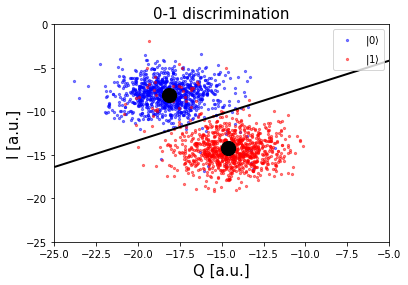

In [81]:
# Plot separatrix on top of scatter
def separatrixPlot(lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')

IQ_01_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_01, x_min, x_max, y_min, y_max, NUM_SHOTS)

## Discriminating the |0⟩, |1⟩ and |2⟩ states 

In [83]:
from qiskit.pulse.library import Waveform ## replaced by Wafeform after 0.25.0

In [90]:
def apply_sideband(pulse, freq):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (SamplePulse): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        SamplePulse: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(freq-rough_qubit_frequency)*t_samples) # no amp for the sine
    
    # create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse')
    
    return sideband_pulse

In [91]:
def create_excited_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the |1> state. 
    This allows us to obtain the 1->2 frequency. We get from the |0> to |1>
    state via a pi pulse using the calibrated qubit frequency. To do the 
    frequency sweep from |1> to |2>, we use a sideband method by tacking
    a sine factor onto the sweep drive pulse.
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Thrown if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try more than 75 frequencies.
    Returns:
        Qobj: Program for freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
        
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")

    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        sigma=drive_sigma,
                                        amp=drive_power,
                                        name='base_12_pulse')
    schedules = []
    for jj, freq in enumerate(freqs):
        
        # add sideband to gaussian pulse
        freq_sweep_12_pulse = apply_sideband(base_12_pulse, freq)
        
        # add commands to schedule
        schedule = pulse.Schedule(name="Frequency = {}".format(freq))

        # Add 0->1 pulse, freq sweep pulse and measure
        schedule |= pulse.Play(pi_pulse_01, drive_chan)
        schedule |= pulse.Play(freq_sweep_12_pulse, drive_chan) << schedule.duration 
        schedule |= measure << schedule.duration # shift measurement to after drive pulses

        schedules.append(schedule)

    num_freqs = len(freqs)
    
    # draw a schedule
    display(schedules[-1].draw(channels=[drive_chan, meas_chan], label=True, scale=1.0))
    
    # assemble freq sweep program 
    # Note: LO is at cal_qubit_freq for each schedule; accounted for by sideband
    excited_freq_sweep_program = assemble(schedules,
                                          backend=backend, 
                                          meas_level=1,
                                          meas_return='avg',
                                          shots=NUM_SHOTS,
                                          schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                         * num_freqs)
    
    return excited_freq_sweep_program

The frequency sweep will go from 4.571800928086361 GHz to 5.001800928086361 GHz using 75 frequencies. The drive power is 0.3.


/Users/mingtsoweii/miniconda3/lib/python3.8/site-packages/qiskit/pulse/schedule.py:1534: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments scale, label, channels are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  warnings.warn('Legacy pulse drawer is deprecated. '


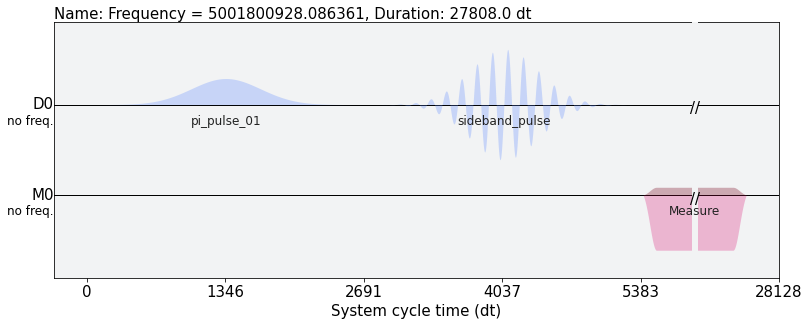

In [92]:
# sweep 400 MHz below 0->1 frequency to catch the 1->2 frequency
num_freqs = 75
excited_sweep_freqs = rough_qubit_frequency + np.linspace(-400*MHz, 30*MHz, num_freqs)
excited_freq_sweep_program = create_excited_freq_sweep_program(excited_sweep_freqs, drive_power=0.3)

# Plot an example schedule to make sure it's valid

In [93]:
excited_freq_sweep_job = backend.run(excited_freq_sweep_program)

<ipython-input-93-05357ecdcc34>:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  excited_freq_sweep_job = backend.run(excited_freq_sweep_program)


In [94]:
print(excited_freq_sweep_job.job_id())
job_monitor(excited_freq_sweep_job)

60727b63dbfb94257527a3b6
Job Status: job has successfully run


In [95]:
# Get job data (avg)
excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)

/Users/mingtsoweii/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


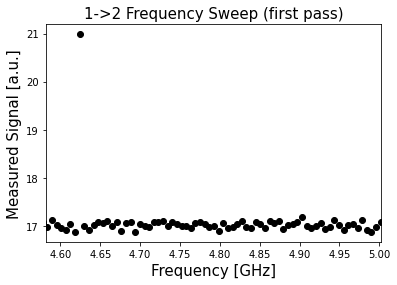

In [96]:
# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.xlim([min(excited_sweep_freqs/GHz)+0.01, max(excited_sweep_freqs/GHz)]) # ignore min point (is off)
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (first pass)", fontsize=15)
plt.show()

In [101]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [99]:
# Prints out relative maxima frequencies in output_data; height gives lower bound (abs val)
def rel_maxima(freqs, output_data, height): 
    """
    Prints out relative maxima frequencies in output_data (can see peaks); height gives upper bound (abs val).
    Be sure to set the height properly or the peak will be ignored!
    Args:
        freqs (list): frequency list
        output_data (list): list of resulting signals
        height (float): upper bound (abs val) on a peak
    Returns:
        list: List containing relative maxima frequencies
    """
    peaks, _ = find_peaks(output_data, height)
    print("Freq. dips: ", freqs[peaks])
    return freqs[peaks]

In [102]:
maxima = rel_maxima(excited_sweep_freqs, np.real(excited_freq_sweep_data), 18)
approx_12_freq = maxima

Freq. dips:  [4.62409823e+09]


The frequency sweep will go from 4.604098225383658 GHz to 4.644098225383658 GHz using 75 frequencies. The drive power is 0.3.


/Users/mingtsoweii/miniconda3/lib/python3.8/site-packages/qiskit/pulse/schedule.py:1534: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments scale, label, channels are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  warnings.warn('Legacy pulse drawer is deprecated. '


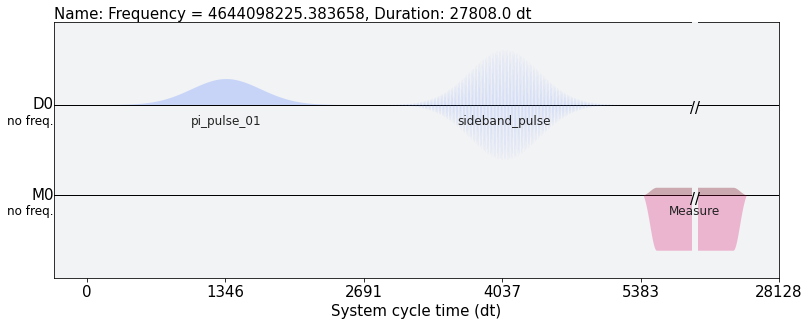

In [103]:
# smaller range refined sweep
num_freqs = 75
refined_excited_sweep_freqs = approx_12_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
refined_excited_freq_sweep_program = create_excited_freq_sweep_program(refined_excited_sweep_freqs, drive_power=0.3)

In [104]:
refined_excited_freq_sweep_job = backend.run(refined_excited_freq_sweep_program)

<ipython-input-104-5d96535366bb>:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  refined_excited_freq_sweep_job = backend.run(refined_excited_freq_sweep_program)


In [105]:
print(refined_excited_freq_sweep_job.job_id())
job_monitor(refined_excited_freq_sweep_job)

60727e25dbfb944b1627a3c5
Job Status: job has successfully run


In [106]:
# Get the refined data (average)
refined_excited_freq_sweep_data = get_job_data(refined_excited_freq_sweep_job, average=True)

In [107]:
# do fit in Hz
(refined_excited_sweep_fit_params, 
 refined_excited_sweep_y_fit) = fit_function(refined_excited_sweep_freqs,
                                     refined_excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-12, 4.624*GHz, 0.05*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

/Users/mingtsoweii/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


/Users/mingtsoweii/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


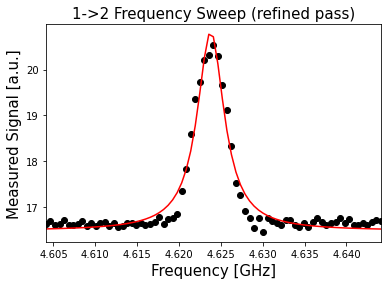

In [108]:
# Note: we are only plotting the real part of the signal
plt.scatter(refined_excited_sweep_freqs/GHz, refined_excited_freq_sweep_data, color='black')
plt.plot(refined_excited_sweep_freqs/GHz, refined_excited_sweep_y_fit, color='red')
plt.xlim([min(refined_excited_sweep_freqs/GHz), max(refined_excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [109]:
_, qubit_12_freq, _, _ = refined_excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

Our updated estimate for the 1->2 transition frequency is 4.6237816 GHz.


In [110]:
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [111]:
# Create schedule
rabi_12_schedules = []

# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    
    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                       sigma=drive_sigma,
                                       amp=drive_amp,
                                       name='base_12_pulse')
    # apply sideband at the 1->2 frequency
    rabi_12_pulse = apply_sideband(base_12_pulse, qubit_12_freq)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(pi_pulse_01, drive_chan) # 0->1
    schedule |= pulse.Play(rabi_12_pulse, drive_chan) << schedule.duration # 1->2 Rabi pulse
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    
    rabi_12_schedules.append(schedule)

In [112]:
# Assemble the schedules into a program
# Note: The LO frequency is at cal_qubit_freq to support the 0->1 pi pulse;
# it is modified for the 1->2 pulse using sidebanding
rabi_12_expt_program = assemble(rabi_12_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: rough_qubit_frequencyqubit_frequencyqubit_frequencyqubit_frequencyqubit_frequency_qubit_frequency_qubit_frequency}]
                                               * num_rabi_points)

In [113]:
rabi_12_job = backend.run(rabi_12_expt_program)

<ipython-input-113-a52f9b93cb08>:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  rabi_12_job = backend.run(rabi_12_expt_program)


In [114]:
print(rabi_12_job.job_id())
job_monitor(rabi_12_job)

6072815c8733253ed7e5ceca
Job Status: job has successfully run


In [175]:
# Get the job data (average)
rabi_12_data = get_job_data(rabi_12_job, average=True)

In [170]:
print(len(rabi_12_data)*0.6)

45.0


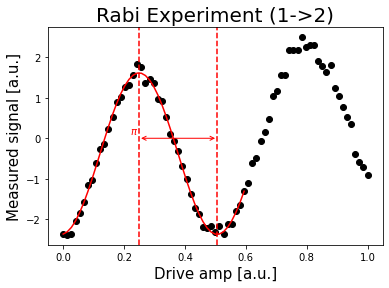

In [190]:
# Note: We only plot the real part of the signal.
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps[:45],
                            rabi_12_data[:45], 
                            lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                            [2, -2.5, 0.4,0.5])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps[:45], rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2]
# account for phi in computing pi amp
pi_amp_12 = (drive_12_period/2/np.pi) *(np.pi+rabi_12_fit_params[3])

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [191]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4.6237816 GHz.
Pi Amplitude (1->2) = 0.2493075855271005


In [192]:
pi_pulse_12 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_12, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_12')
# make sure this pulse is sidebanded
pi_pulse_12 = apply_sideband(pi_pulse_12, qubit_12_freq)

In [193]:
# Create the three schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="zero schedule")
zero_schedule |= measure

# Excited state schedule
one_schedule = pulse.Schedule(name="one schedule")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan)
one_schedule |= measure << one_schedule.duration

# Excited state schedule
two_schedule = pulse.Schedule(name="two schedule")
two_schedule |= pulse.Play(pi_pulse_01, drive_chan)
two_schedule |= pulse.Play(pi_pulse_12, drive_chan) << two_schedule.duration
two_schedule |= measure << two_schedule.duration

In [194]:
# Assemble the schedules into a program
IQ_012_program = assemble([zero_schedule, one_schedule, two_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: rough_qubit_frequency}] * 3)

In [195]:
# Assemble the schedules into a program
IQ_012_program = assemble([zero_schedule, one_schedule, two_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: rough_qubit_frequency}] * 3)

In [196]:
IQ_012_job = backend.run(IQ_012_program)

<ipython-input-196-c6097db95b4a>:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  IQ_012_job = backend.run(IQ_012_program)


In [197]:
print(IQ_012_job.job_id())
job_monitor(IQ_012_job)

6072864b01ba967899179e41
Job Status: job has successfully run


In [312]:
# Get job data (single); split for zero, one and two
IQ_012_data = get_job_data(IQ_012_job, average=False)
zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

In [313]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

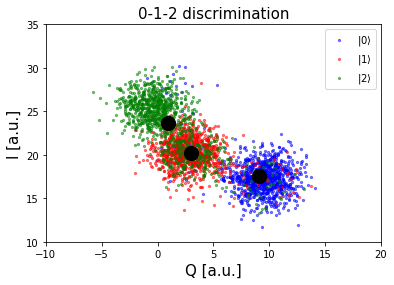

In [355]:
x_min = -10
x_max = 20
y_min = 10
y_max = 35
IQ_012_plot(x_min, x_max, y_min, y_max)

In [356]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  
two_data_reshaped = reshape_complex_vec(two_data)  

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape) # verify IQ data shape

(3072, 2)


3072
[1. 1. 1.]
0.8079427083333334


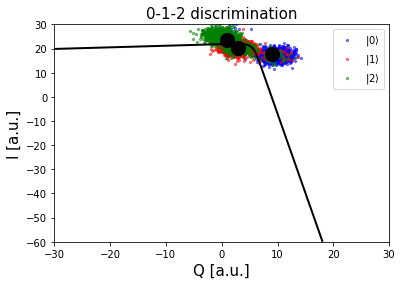

In [377]:
# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2*np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)
# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)
# test on some simple data 
print(LDA_012.predict([[0, 0], [-10, 0], [-15, -5]]))
# Compute accuracy
score_012 = LDA_012.score(IQ_012_test, state_012_test)
print(score_012)
IQ_012_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)

/Users/mingtsoweii/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.841796875


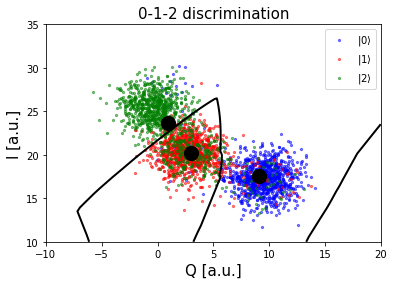

In [358]:
from sklearn.neural_network import MLPClassifier
IQ_012_plot(x_min, x_max, y_min, y_max)
NN_012 = MLPClassifier(solver='lbfgs',max_iter=1000)
NN_012.fit(IQ_012_train, state_012_train)
separatrixPlot(NN_012, x_min, x_max, y_min, y_max, NUM_SHOTS)
print(NN_012.score(IQ_012_test, state_012_test))

0.8255208333333334


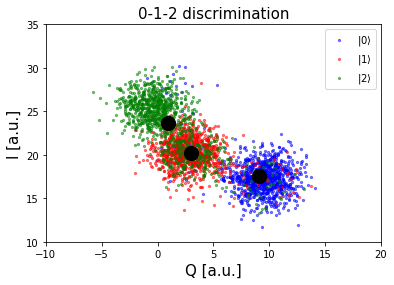

In [249]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
IQ_012_plot(x_min, x_max, y_min, y_max)
QDA_012 = QuadraticDiscriminantAnalysis()
QDA_012.fit(IQ_012_train, state_012_train)
scoreq_012 = QDA_012.score(IQ_012_test, state_012_test)
print(scoreq_012)

/Users/mingtsoweii/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.8411458333333334


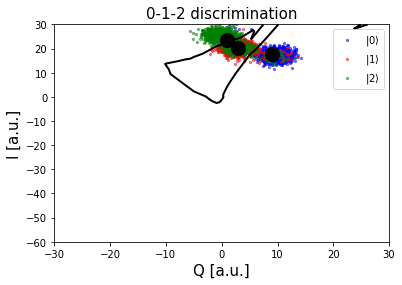

In [362]:
from sklearn.neural_network import MLPClassifier
IQ_012_plot(x_min, x_max, y_min, y_max)
NN_012 = MLPClassifier(hidden_layer_sizes = (100,100,),solver='lbfgs',max_iter=1000)
NN_012.fit(IQ_012_train, state_012_train)
separatrixPlot(NN_012, x_min, x_max, y_min, y_max, NUM_SHOTS)
print(NN_012.score(IQ_012_test, state_012_test))

### Qudit Gates Class

Currently we only have two gate operations: xcyc (cyclic shift) and axcyc (acyclic shift)

In [255]:
from qiskit.pulse import *
from qiskit.pulse import library as pulse_lib
class QuditGates:
    def __init__(self, pi_amp_01, pi_amp_12, trans_freq_01, trans_freq_12, chan, dt):
#         self.sched = sched
        self.dt = dt
        self.pi_amp_01 = pi_amp_01
        self.pi_amp_12 = pi_amp_12
        self.chan = chan
        self.trans_freq_01 = trans_freq_01
        self.trans_freq_12 = trans_freq_12
        drive_sigma = 0.075*1e-6
        self.drive_sigma_dt = int(drive_sigma/dt) - (int(drive_sigma/dt%16))
        self.drive_samples_dt = 8*self.drive_sigma_dt
        self.pi_pul_01 = pulse_lib.gaussian(duration=self.drive_samples_dt,
                                 amp=self.pi_amp_01,
                                 sigma=self.drive_sigma_dt,
                                 )
        self.base_pulse = pulse_lib.gaussian(duration=self.drive_samples_dt,
                                        sigma=self.drive_sigma_dt,
                                        amp=self.pi_amp_12)
#         pi_pulse_12 = apply_sideband_n(base_pulse, trans_freq_12)
    
    def apply_sideband_n(self, base_pulse, freq):
        t_samples = np.linspace(0, dt*self.drive_samples_dt, num=self.drive_samples_dt)
        sine_pulse = np.sin(2*np.pi*(freq-self.trans_freq_01)*t_samples)
        sideband_pulse = Waveform(np.multiply(np.real(base_pulse.samples), sine_pulse), name='sideband_pulse')
        return sideband_pulse
    
    def xcyc(self):
        '''This the gate corresponding to the operator
        |n> --> |(n+1) mod 3>.'''
        pi_pul_12 = self.apply_sideband_n(self.base_pulse, trans_freq_12)
        with build() as xcyc_pulse:
            play(pi_pul_12, self.chan)
            play(self.pi_pul_01, self.chan)
        sched = Schedule()
        sched += xcyc_pulse
        return sched
    
    def xacyc(self):
        '''This the gate corresponding to the operator
        |n> --> |(n-1) mod 3>.'''
        pi_pul_12 = self.apply_sideband_n(self.base_pulse, trans_freq_12)
        with build as xacyc_pulse:
            play(self.pi_pul_01, self.chan)
            play(pi_pul_12, self.chan)
        sched = Schedule()
        sched += xacyc_pulse
        return sched

In [363]:
from qiskit.pulse import Schedule

trans_freq_01=4971800930
trans_freq_12=4623781600

pi_amp_01=0.14096173612665405
pi_amp_12=0.2493075855271005
gate=QuditGates(pi_amp_01, pi_amp_12, trans_freq_01, trans_freq_12, drive_chan, dt)
cyclic_shift_sched = Schedule()
cyclic_shift_sched += gate.xcyc()
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])
cyclic_shift_sched |= measure << cyclic_shift_sched.duration

In [364]:
cyclic_shift_program = assemble(cyclic_shift_sched,
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: rough_qubit_frequency}])

/Users/mingtsoweii/miniconda3/lib/python3.8/site-packages/qiskit/pulse/schedule.py:1534: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  warnings.warn('Legacy pulse drawer is deprecated. '


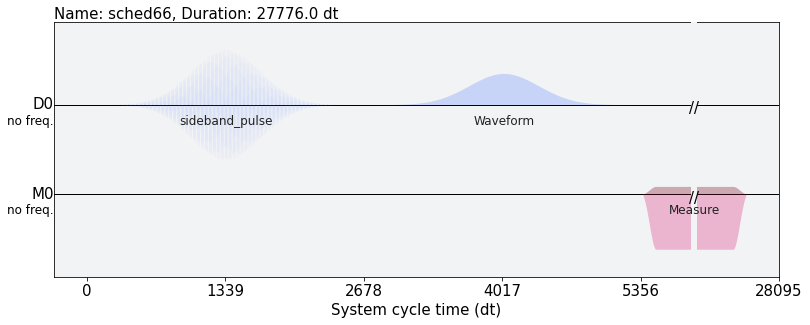

In [365]:
cyclic_shift_sched.draw(label=True)

In [366]:
cyclic_shift_job = backend.run(cyclic_shift_program)

<ipython-input-366-cf96e0c6d087>:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  cyclic_shift_job = backend.run(cyclic_shift_program)


In [367]:
job_monitor(cyclic_shift_job)

Job Status: job has successfully run


In [368]:
cyclic_shift_data = get_job_data(cyclic_shift_job, average=False)
cyclic_shift_data

[array([-0.43826857-17.75057102j,  0.77977371-19.09293889j,
        -1.43069538-19.3876931j , ...,  1.24680208-21.17592152j,
        -2.06402891-21.24659521j, -0.23964875-21.21402325j])]

In [369]:
cyclic_shift_reshaped=reshape_complex_vec(cyclic_shift_data[0])

In [370]:
def IQ_012_measure_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # measured data plotted in blue
    plt.scatter(np.real(cyclic_shift_data), np.imag(cyclic_shift_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    mean_data = np.mean(cyclic_shift_data) # takes mean of both real and imaginary parts
    plt.scatter(np.real(mean_data), np.imag(mean_data), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination of measured data", fontsize=15)

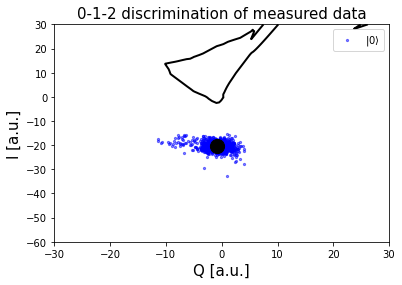

In [374]:
x_min = -30
x_max = 30
y_min = -60
y_max = 30
IQ_012_measure_plot(x_min, x_max, y_min, y_max)
output=NN_012.predict(cyclic_shift_reshaped)
separatrixPlot(NN_012, x_min, x_max, y_min, y_max, NUM_SHOTS)

In [375]:
print(output)

[2. 2. 2. ... 2. 2. 2.]


In [376]:
unique, counts = np.unique(output, return_counts=True)
dict(zip(unique, counts))


{2.0: 1024}

The discriminator seems to be away from the measure data of the cyclic shift. This problem needs to be solved in the future.

### Compare to LDA discriminator

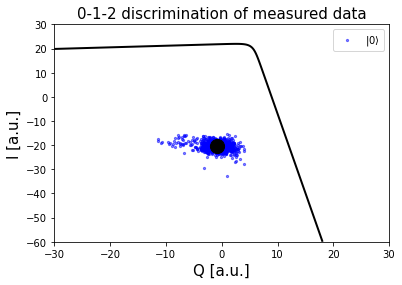

In [378]:
x_min = -30
x_max = 30
y_min = -60
y_max = 30
IQ_012_measure_plot(x_min, x_max, y_min, y_max)
output_LDA=LDA_012.predict(cyclic_shift_reshaped)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)

In [379]:
unique, counts = np.unique(output_LDA, return_counts=True)
dict(zip(unique, counts))

{1.0: 1024}

It has the same issue of classification of the measured data.